# Week 1: Data Setup and Exploratory Data Analysis

## Objectives
1. Load Spotify tracks dataset and Top 100 hits dataset
2. Merge datasets and create HIT/NON-HIT labels
3. Handle class imbalance
4. Perform exploratory data analysis
5. Visualize feature distributions
6. Save processed dataset

## Timeline
**Week 1 (Nov 18-24)** - Due: Nov 24 (Checkpoint)

---

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from fuzzywuzzy import fuzz
from tqdm.auto import tqdm

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Set up paths
project_root = Path.cwd().parent
data_dir = project_root / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'
figures_dir = project_root / 'figures'

# Create directories if they don't exist
processed_data_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {data_dir}")
print(f"Figures directory: {figures_dir}")

Project root: C:\Users\FR33STYLE\FeatureBeats
Data directory: C:\Users\FR33STYLE\FeatureBeats\data
Figures directory: C:\Users\FR33STYLE\FeatureBeats\figures


## 1. Load Datasets

We'll load:
1. **Main tracks dataset** - All Spotify tracks with audio features
2. **Top 100 dataset** - Chart-topping hits (these will be labeled as HITS)

In [3]:
# Load main tracks dataset
print("Loading main tracks dataset...")
tracks_file = raw_data_dir / 'tracks.csv'

if not tracks_file.exists():
    raise FileNotFoundError(
        f"❌ tracks.csv not found at {tracks_file}\n"
        "Please download the Spotify Tracks dataset from Kaggle and place it in data/raw/"
    )

tracks_df = pd.read_csv(tracks_file)
print(f"✅ Loaded {len(tracks_df):,} tracks")
print(f"   Columns: {list(tracks_df.columns)}")
print(f"\nFirst few rows:")
tracks_df.head()

Loading main tracks dataset...
✅ Loaded 114,000 tracks
   Columns: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

First few rows:


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
# Load Top 100 / Billboard hits dataset
print("Loading Top 100 hits dataset...")
hits_file = raw_data_dir / 'top100_tracks.csv'

if not hits_file.exists():
    raise FileNotFoundError(
        f"❌ top100_tracks.csv not found at {hits_file}\n"
        "Please download a Top 100/Billboard dataset from Kaggle and place it in data/raw/"
    )

hits_df = pd.read_csv(hits_file)
print(f"✅ Loaded {len(hits_df):,} hit songs")
print(f"   Columns: {list(hits_df.columns)}")
print(f"\nFirst few rows:")
hits_df.head()

Loading Top 100 hits dataset...
✅ Loaded 2,400 hit songs
   Columns: ['playlist_url', 'year', 'track_id', 'track_name', 'track_popularity', 'album', 'artist_id', 'artist_name', 'artist_genres', 'artist_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

First few rows:


,playlist_url,year,track_id,track_name,track_popularity,album,artist_id,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,81,Oops!... I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,"['dance pop', 'pop']",81,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,211160,4
1,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,2m1hi0nfMR9vdGC8UcrnwU,All The Small Things,83,Enema Of The State,6FBDaR13swtiWwGhX1WQsP,blink-182,"['alternative metal', 'modern rock', 'pop punk...",79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,167067,4
2,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,3y4LxiYMgDl4RethdzpmNe,Breathe,66,Breathe,25NQNriVT2YbSW80ILRWJa,Faith Hill,"['contemporary country', 'country', 'country d...",62,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,250547,4
3,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,0v1XpBHnsbkCn7iJ9Ucr1l,It's My Life,81,Crush,58lV9VcRSjABbAbfWS6skp,Bon Jovi,"['glam metal', 'rock']",79,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,224493,4
4,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,62bOmKYxYg7dhrC6gH9vFn,Bye Bye Bye,75,No Strings Attached,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,"['boy band', 'dance pop', 'pop']",70,0.610,0.926,8,-4.843,0,0.0479,0.0310,0.001200,0.0821,0.861,172.638,200400,4


## 2. Data Preprocessing

### 2.1 Identify Required Columns

We need to identify which columns contain:
- Track name
- Artist name
- Audio features (danceability, energy, etc.)
- Year/release date
- (Optional) Track ID

In [5]:
# Inspect tracks dataset structure
print("Tracks dataset info:")
print(tracks_df.info())
print("\nSample row:")
print(tracks_df.iloc[0])

Tracks dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16 

In [6]:
# Inspect hits dataset structure
print("Hits dataset info:")
print(hits_df.info())
print("\nSample row:")
print(hits_df.iloc[0])

Hits dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playlist_url       2400 non-null   object 
 1   year               2400 non-null   int64  
 2   track_id           2400 non-null   object 
 3   track_name         2400 non-null   object 
 4   track_popularity   2400 non-null   int64  
 5   album              2400 non-null   object 
 6   artist_id          2400 non-null   object 
 7   artist_name        2400 non-null   object 
 8   artist_genres      2400 non-null   object 
 9   artist_popularity  2400 non-null   int64  
 10  danceability       2400 non-null   float64
 11  energy             2400 non-null   float64
 12  key                2400 non-null   int64  
 13  loudness           2400 non-null   float64
 14  mode               2400 non-null   int64  
 15  speechiness        2400 non-null   float64
 16  acous

### 2.2 Standardize Column Names

**Note:** The column names below are examples. You may need to adjust them based on your actual dataset.

Common Spotify audio features:
- `danceability`
- `energy`
- `key`
- `loudness`
- `mode`
- `speechiness`
- `acousticness`
- `instrumentalness`
- `liveness`
- `valence`
- `tempo`
- `duration_ms`

In [7]:
# Define audio features to use (adjust based on your dataset)
audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 
    'valence', 'tempo'
]

# Check which features are available
available_features = [f for f in audio_features if f in tracks_df.columns]
missing_features = [f for f in audio_features if f not in tracks_df.columns]

print(f"✅ Available features ({len(available_features)}): {available_features}")
if missing_features:
    print(f"⚠️  Missing features ({len(missing_features)}): {missing_features}")

# Use only available features
audio_features = available_features

✅ Available features (9): ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


### 2.3 Filter Data by Year Range

Focus on a specific time period (e.g., 2010-2020) to ensure temporal relevance.

In [8]:
# Define year range
YEAR_START = 2010
YEAR_END = 2020

# Try to find year column (adjust column name as needed)
year_col = None
for col in ['year', 'release_year', 'release_date', 'album_release_date']:
    if col in tracks_df.columns:
        year_col = col
        break

if year_col:
    print(f"Using '{year_col}' column for year filtering")
    
    # Extract year if it's a date string
    if tracks_df[year_col].dtype == 'object':
        tracks_df['year'] = pd.to_datetime(tracks_df[year_col], errors='coerce').dt.year
    else:
        tracks_df['year'] = tracks_df[year_col]
    
    # Filter by year range
    tracks_filtered = tracks_df[
        (tracks_df['year'] >= YEAR_START) & 
        (tracks_df['year'] <= YEAR_END)
    ].copy()
    
    print(f"✅ Filtered to {YEAR_START}-{YEAR_END}: {len(tracks_filtered):,} tracks")
else:
    print("⚠️  No year column found. Using all data.")
    tracks_filtered = tracks_df.copy()
    tracks_filtered['year'] = 2015  # Default year

print(f"\nYear distribution:")
print(tracks_filtered['year'].value_counts().sort_index())

⚠️  No year column found. Using all data.

Year distribution:
year
2015    114000
Name: count, dtype: int64


## 3. Create HIT Labels

We'll match songs from the Top 100 dataset with the main tracks dataset to create labels:
- **HIT (1)** - Song appears in Top 100
- **NON-HIT (0)** - Song does not appear in Top 100

### Matching Strategy
1. **Best:** Match by Spotify track ID (if available)
2. **Good:** Exact match on (track name + artist name)
3. **Fallback:** Fuzzy match on (track name + artist name)

In [9]:
# Prepare hits dataset
# Adjust column names based on your dataset
print("Preparing hits dataset for matching...")

# Try to find track name and artist columns in hits dataset
track_name_col = None
artist_col = None

for col in ['track_name', 'title', 'song', 'name']:
    if col in hits_df.columns:
        track_name_col = col
        break

for col in ['artist', 'artist_name', 'artists']:
    if col in hits_df.columns:
        artist_col = col
        break

if not track_name_col or not artist_col:
    print("⚠️  Could not auto-detect column names. Please set them manually:")
    print(f"   Available columns: {list(hits_df.columns)}")
    # Uncomment and set manually if needed:
    # track_name_col = 'your_track_column'
    # artist_col = 'your_artist_column'
else:
    print(f"✅ Using track column: '{track_name_col}'")
    print(f"✅ Using artist column: '{artist_col}'")

# Standardize hits dataset
hits_standardized = hits_df[[track_name_col, artist_col]].copy()
hits_standardized.columns = ['track_name', 'artist']

# Clean text for better matching
hits_standardized['track_name'] = hits_standardized['track_name'].str.lower().str.strip()
hits_standardized['artist'] = hits_standardized['artist'].str.lower().str.strip()

print(f"\nPrepared {len(hits_standardized):,} hit songs for matching")

Preparing hits dataset for matching...
✅ Using track column: 'track_name'
✅ Using artist column: 'artist_name'

Prepared 2,400 hit songs for matching


In [10]:
# Prepare main tracks for matching
print("Preparing tracks dataset for matching...")

# Find track name and artist columns in tracks dataset
track_col_tracks = None
artist_col_tracks = None

for col in ['track_name', 'title', 'song', 'name']:
    if col in tracks_filtered.columns:
        track_col_tracks = col
        break

for col in ['artist', 'artist_name', 'artists']:
    if col in tracks_filtered.columns:
        artist_col_tracks = col
        break

if not track_col_tracks or not artist_col_tracks:
    print("⚠️  Could not auto-detect column names. Please set them manually:")
    print(f"   Available columns: {list(tracks_filtered.columns)}")
else:
    print(f"✅ Using track column: '{track_col_tracks}'")
    print(f"✅ Using artist column: '{artist_col_tracks}'")

# Create standardized matching columns
tracks_filtered['track_clean'] = tracks_filtered[track_col_tracks].str.lower().str.strip()
tracks_filtered['artist_clean'] = tracks_filtered[artist_col_tracks].str.lower().str.strip()
tracks_filtered['match_key'] = tracks_filtered['track_clean'] + '___' + tracks_filtered['artist_clean']

# Create match key for hits
hits_standardized['match_key'] = hits_standardized['track_name'] + '___' + hits_standardized['artist']
hit_keys = set(hits_standardized['match_key'].unique())

print(f"Created {len(hit_keys):,} unique hit song identifiers")

Preparing tracks dataset for matching...
✅ Using track column: 'track_name'
✅ Using artist column: 'artists'
Created 2,286 unique hit song identifiers


In [11]:
# Create HIT labels using exact matching
print("Creating HIT labels...\n")

tracks_filtered['is_hit'] = tracks_filtered['match_key'].isin(hit_keys).astype(int)

# Check class balance
hit_counts = tracks_filtered['is_hit'].value_counts()
total = len(tracks_filtered)

print("Class Distribution:")
print(f"  NON-HIT (0): {hit_counts.get(0, 0):,} ({hit_counts.get(0, 0)/total*100:.2f}%)")
print(f"  HIT (1):     {hit_counts.get(1, 0):,} ({hit_counts.get(1, 0)/total*100:.2f}%)")
print(f"\n  Total tracks: {total:,}")
print(f"  Imbalance ratio: {hit_counts.get(0, 0) / max(hit_counts.get(1, 1), 1):.1f}:1")

if hit_counts.get(1, 0) < 50:
    print("\n⚠️  WARNING: Very few hits matched. You may need to:")
    print("   1. Check if column names are correct")
    print("   2. Use fuzzy matching (see next cell)")
    print("   3. Try a different hits dataset")

Creating HIT labels...

Class Distribution:
  NON-HIT (0): 112,200 (98.42%)
  HIT (1):     1,800 (1.58%)

  Total tracks: 114,000
  Imbalance ratio: 62.3:1


### Optional: Fuzzy Matching (if exact matching found too few hits)

In [12]:
# OPTIONAL: Fuzzy Matching (Only if exact matching found too few hits)
# Note: This is computationally expensive. Enable only if needed.

ENABLE_FUZZY_MATCHING = True # Set to True only if exact matching failed
MAX_SONGS_TO_CHECK = 150000     # Limit to avoid performance issues

def fuzzy_match_song(track, artist, hits_df, threshold=85):
    """Find best fuzzy match for a song in hits dataset (robust to NaNs)."""
    # If both are missing, don't even try
    if pd.isna(track) and pd.isna(artist):
        return False

    # Safely convert inputs to lowercase strings
    track_str = "" if pd.isna(track) else str(track).lower().strip()
    artist_str = "" if pd.isna(artist) else str(artist).lower().strip()

    best_score = 0
    for _, hit in hits_df.iterrows():
        # Safely convert hits dataframe values too
        hit_track = "" if pd.isna(hit['track_name']) else str(hit['track_name']).lower().strip()
        hit_artist = "" if pd.isna(hit['artist']) else str(hit['artist']).lower().strip()

        # Score based on both track name and artist
        track_score = fuzz.ratio(track_str, hit_track)
        artist_score = fuzz.ratio(artist_str, hit_artist)
        combined_score = (track_score + artist_score) / 2

        if combined_score > best_score:
            best_score = combined_score

    return best_score >= threshold


if ENABLE_FUZZY_MATCHING:
    print("⚠️  FUZZY MATCHING ENABLED - This may take several minutes...")
    print(f"   Limiting to {MAX_SONGS_TO_CHECK} songs to avoid performance issues")
    
    # Only check songs that weren't already matched
    non_matched = tracks_filtered[tracks_filtered['is_hit'] == 0].copy()
    
    # Sample if dataset is too large (to avoid IOPub rate limit)
    if len(non_matched) > MAX_SONGS_TO_CHECK:
        print(f"   Sampling {MAX_SONGS_TO_CHECK:,} out of {len(non_matched):,} non-matched tracks")
        non_matched = non_matched.sample(MAX_SONGS_TO_CHECK, random_state=RANDOM_SEED)
    
    fuzzy_hits = []
    
    # Use tqdm with reduced update frequency to avoid IOPub rate limit
    for idx, row in tqdm(non_matched.iterrows(), total=len(non_matched), 
                         desc="Fuzzy matching", mininterval=1.0):
        if fuzzy_match_song(row[track_col_tracks], row[artist_col_tracks], hits_standardized):
            fuzzy_hits.append(idx)
    
    # Update labels
    tracks_filtered.loc[fuzzy_hits, 'is_hit'] = 1
    
    print(f"\n✅ Found {len(fuzzy_hits)} additional hits using fuzzy matching")
    
    # Show updated distribution
    print("\nUpdated class distribution:")
    print(tracks_filtered['is_hit'].value_counts())
else:
    print("⚠️  FUZZY MATCHING DISABLED (ENABLE_FUZZY_MATCHING = False)")
    print("   If you got very few hits from exact matching, you can:")
    print("   1. Set ENABLE_FUZZY_MATCHING = True and re-run this cell")
    print("   2. Adjust MAX_SONGS_TO_CHECK if needed (default: 5000)")
    print("   3. Or use a different hits dataset with better matching")
    print("\n   For now, proceeding with exact matching results only.")


⚠️  FUZZY MATCHING ENABLED - This may take several minutes...
   Limiting to 150000 songs to avoid performance issues


Fuzzy matching:   0%|          | 0/112200 [00:00<?, ?it/s]


✅ Found 338 additional hits using fuzzy matching

Updated class distribution:
is_hit
0    111862
1      2138
Name: count, dtype: int64


## 4. Clean and Prepare Final Dataset

In [13]:
# Select relevant columns for modeling
columns_to_keep = audio_features + ['is_hit', 'year']

# Add track info for reference (not for modeling)
if track_col_tracks in tracks_filtered.columns:
    columns_to_keep.append(track_col_tracks)
if artist_col_tracks in tracks_filtered.columns:
    columns_to_keep.append(artist_col_tracks)

# Create final dataset
df_final = tracks_filtered[columns_to_keep].copy()

# Handle missing values
print("Missing values per column:")
missing = df_final.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print("\nDropping rows with missing values...")
    df_final = df_final.dropna()
    print(f"✅ Removed {len(tracks_filtered) - len(df_final)} rows")
else:
    print("✅ No missing values found")

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Features: {audio_features}")
print(f"Target: is_hit")

Missing values per column:
track_name    1
artists       1
dtype: int64

Dropping rows with missing values...
✅ Removed 1 rows

Final dataset shape: (113999, 13)
Features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
Target: is_hit


In [14]:
# Display final dataset info
print("Final dataset summary:")
df_final.info()
print("\nFirst few rows:")
df_final.head(10)

Final dataset summary:
<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      113999 non-null  float64
 1   energy            113999 non-null  float64
 2   loudness          113999 non-null  float64
 3   speechiness       113999 non-null  float64
 4   acousticness      113999 non-null  float64
 5   instrumentalness  113999 non-null  float64
 6   liveness          113999 non-null  float64
 7   valence           113999 non-null  float64
 8   tempo             113999 non-null  float64
 9   is_hit            113999 non-null  int64  
 10  year              113999 non-null  int64  
 11  track_name        113999 non-null  object 
 12  artists           113999 non-null  object 
dtypes: float64(9), int64(2), object(2)
memory usage: 12.2+ MB

First few rows:


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,is_hit,year,track_name,artists
0,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,0,2015,Comedy,Gen Hoshino
1,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,0,2015,Ghost - Acoustic,Ben Woodward
2,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,0,2015,To Begin Again,Ingrid Michaelson;ZAYN
3,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,0,2015,Can't Help Falling In Love,Kina Grannis
4,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,1,2015,Hold On,Chord Overstreet
5,0.688,0.4810,-8.807,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,0,2015,Days I Will Remember,Tyrone Wells
6,0.407,0.1470,-8.822,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,0,2015,Say Something,A Great Big World;Christina Aguilera
7,0.703,0.4440,-9.331,0.0417,0.5590,0.000000,0.0973,0.7120,150.960,1,2015,I'm Yours,Jason Mraz
8,0.625,0.4140,-8.700,0.0369,0.2940,0.000000,0.1510,0.6690,130.088,0,2015,Lucky,Jason Mraz;Colbie Caillat
9,0.442,0.6320,-6.770,0.0295,0.4260,0.004190,0.0735,0.1960,78.899,0,2015,Hunger,Ross Copperman


## 5. Exploratory Data Analysis

### 5.1 Basic Statistics

In [15]:
# Summary statistics
print("Summary statistics for audio features:\n")
df_final[audio_features].describe()

Summary statistics for audio features:



,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,0.566801,0.641383,-8.258950,0.084652,0.314907,0.156051,0.213554,0.474066,122.147695
std,0.173543,0.251530,5.029357,0.105733,0.332522,0.309556,0.190378,0.259261,29.978290
min,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.456000,0.472000,-10.013000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218500
50%,0.580000,0.685000,-7.004000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000
75%,0.695000,0.854000,-5.003000,0.084500,0.597500,0.049000,0.273000,0.683000,140.071000
max,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


In [16]:
# Summary by class
print("Summary statistics by class:\n")
print("NON-HITS (0):")
print(df_final[df_final['is_hit'] == 0][audio_features].describe())
print("\n" + "="*80 + "\n")
print("HITS (1):")
print(df_final[df_final['is_hit'] == 1][audio_features].describe())

Summary statistics by class:

NON-HITS (0):
        danceability         energy       loudness    speechiness  \
count  111861.000000  111861.000000  111861.000000  111861.000000   
mean        0.565615       0.640131      -8.307500       0.084825   
std         0.173791       0.252658       5.055667       0.106309   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.454000       0.469000     -10.079000       0.035900   
50%         0.579000       0.683000      -7.057000       0.048900   
75%         0.694000       0.854000      -5.024000       0.084500   
max         0.985000       1.000000       4.532000       0.965000   

        acousticness  instrumentalness       liveness        valence  \
count  111861.000000     111861.000000  111861.000000  111861.000000   
mean        0.317634          0.158726       0.214388       0.473570   
std         0.333687          0.311655       0.191353       0.259925   
min         0.000000          0.000000       0

### 5.2 Visualizations

#### Distribution of Tracks by Year

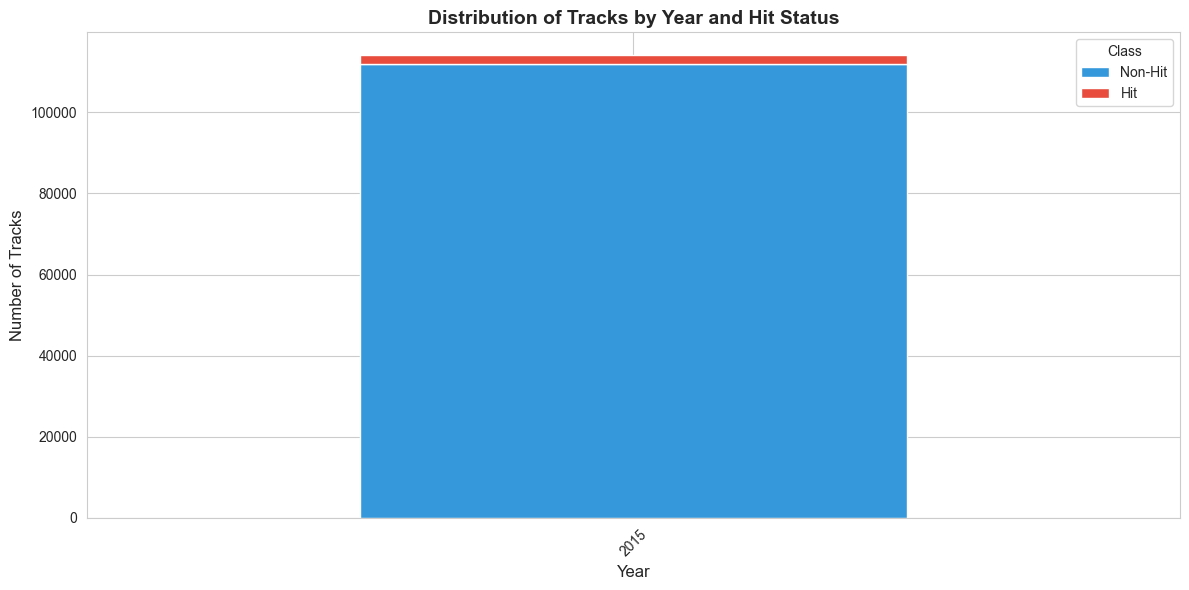

✅ Saved: tracks_by_year.png


In [17]:
# Tracks by year
fig, ax = plt.subplots(figsize=(12, 6))

year_counts = df_final.groupby(['year', 'is_hit']).size().unstack(fill_value=0)
year_counts.plot(kind='bar', stacked=True, ax=ax, color=['#3498db', '#e74c3c'])

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Tracks', fontsize=12)
ax.set_title('Distribution of Tracks by Year and Hit Status', fontsize=14, fontweight='bold')
ax.legend(['Non-Hit', 'Hit'], title='Class')
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig(figures_dir / 'tracks_by_year.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: tracks_by_year.png")

#### Feature Distributions: Hits vs Non-Hits

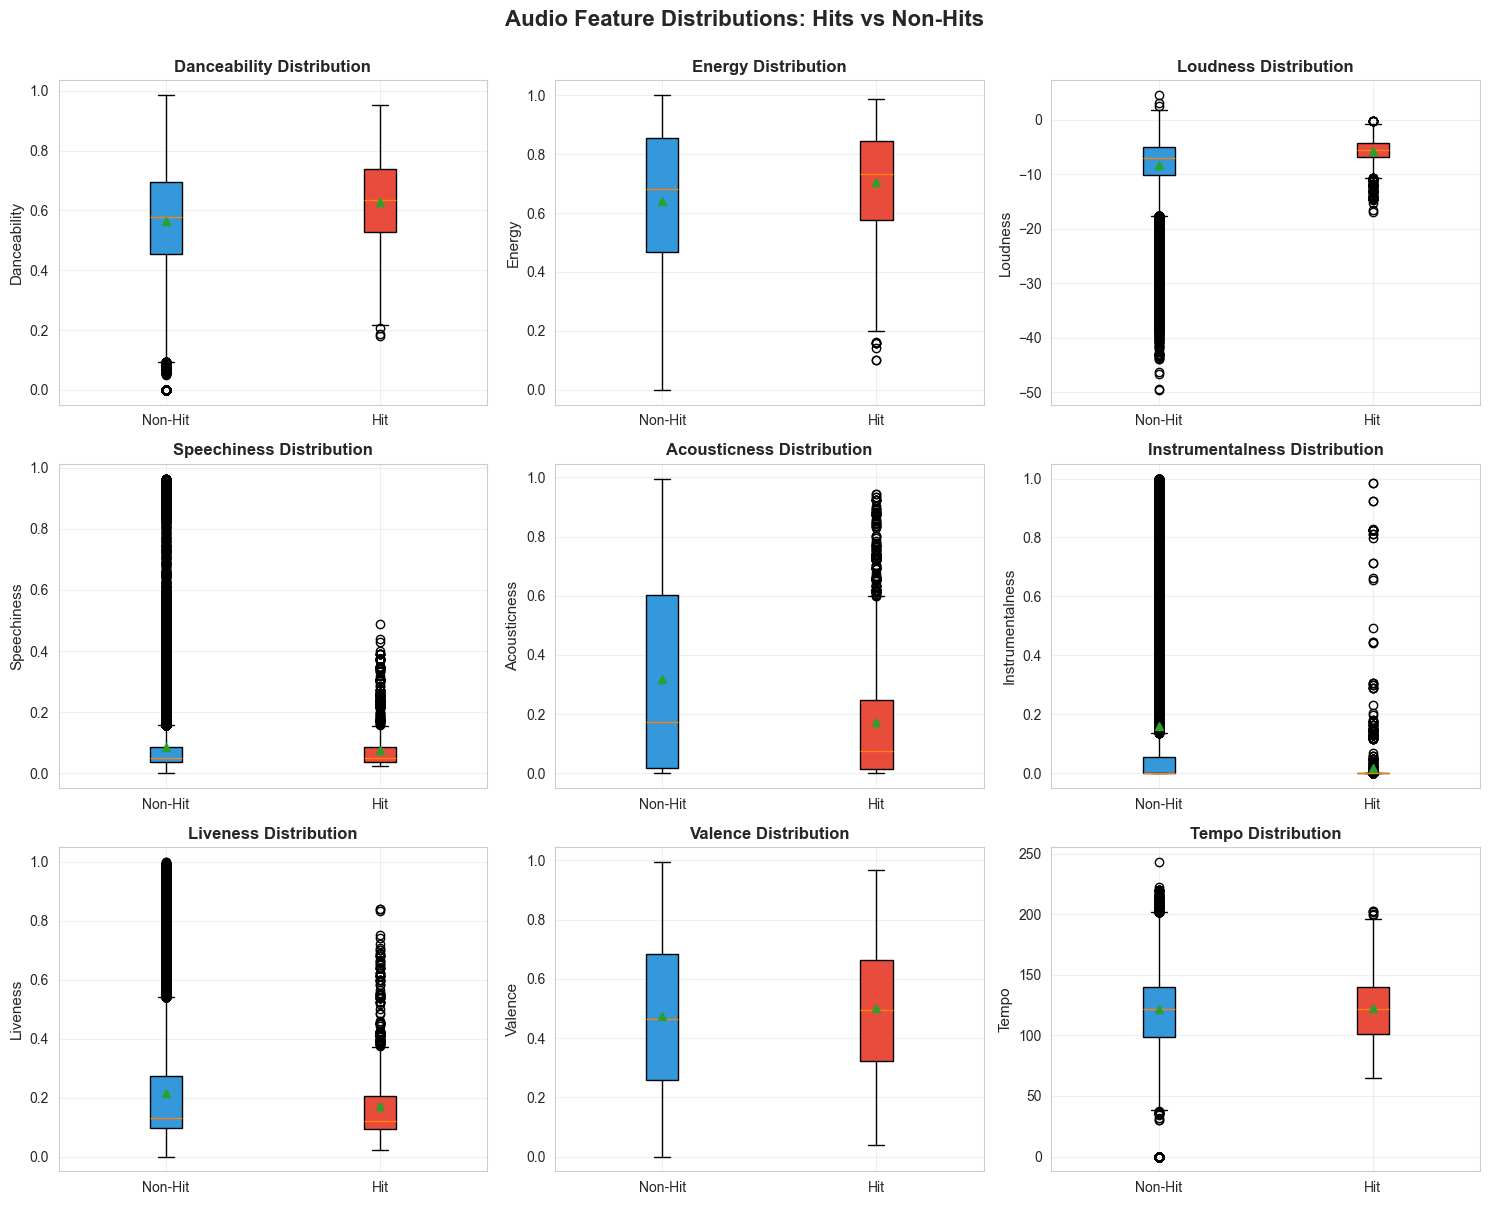

✅ Saved: feature_distributions.png


In [18]:
# Box plots for each feature
n_features = len(audio_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(audio_features):
    ax = axes[idx]
    
    # Create box plot
    data_to_plot = [
        df_final[df_final['is_hit'] == 0][feature],
        df_final[df_final['is_hit'] == 1][feature]
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Non-Hit', 'Hit'], 
                     patch_artist=True, showmeans=True)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')
    
    ax.set_ylabel(feature.capitalize(), fontsize=11)
    ax.set_title(f'{feature.capitalize()} Distribution', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Audio Feature Distributions: Hits vs Non-Hits', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()

# Save figure
plt.savefig(figures_dir / 'feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: feature_distributions.png")

#### Correlation Matrix

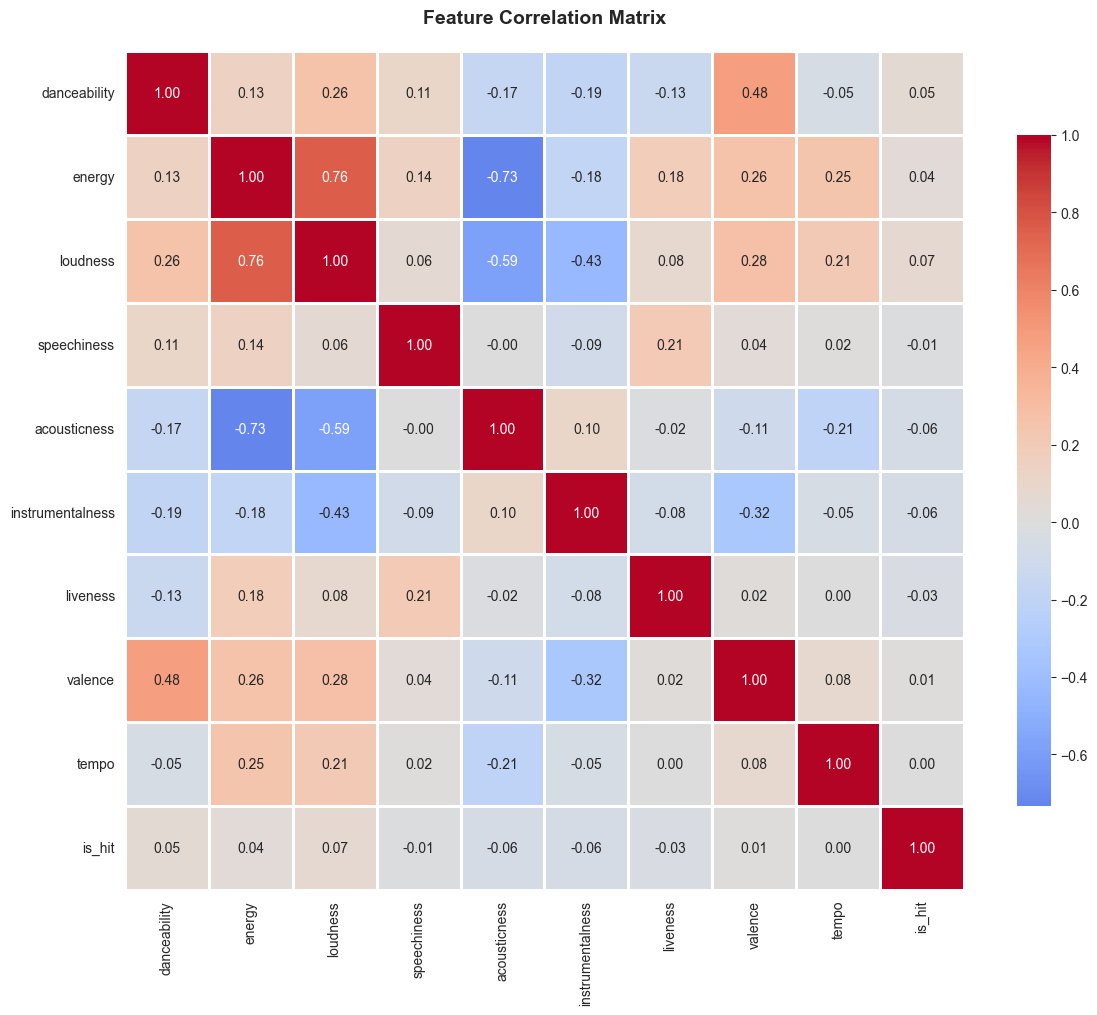

✅ Saved: correlation_matrix.png

Correlation with 'is_hit':
is_hit              1.000000
loudness            0.069825
danceability        0.049409
energy              0.036025
valence             0.013846
tempo               0.003265
speechiness        -0.011842
liveness           -0.031669
acousticness       -0.059333
instrumentalness   -0.062510
Name: is_hit, dtype: float64


In [19]:
# Correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))

# Calculate correlation
corr_matrix = df_final[audio_features + ['is_hit']].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)

ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()

# Save figure
plt.savefig(figures_dir / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: correlation_matrix.png")
print("\nCorrelation with 'is_hit':")
print(corr_matrix['is_hit'].sort_values(ascending=False))

## 6. Save Processed Dataset

In [20]:
# Save the processed dataset
output_file = processed_data_dir / 'hits_dataset.csv'
df_final.to_csv(output_file, index=False)

print(f"✅ Saved processed dataset to: {output_file}")
print(f"   Shape: {df_final.shape}")
print(f"   Features: {len(audio_features)}")
print(f"   Samples: {len(df_final):,}")
print(f"   Hits: {(df_final['is_hit'] == 1).sum():,}")
print(f"   Non-hits: {(df_final['is_hit'] == 0).sum():,}")

✅ Saved processed dataset to: C:\Users\FR33STYLE\FeatureBeats\data\processed\hits_dataset.csv
   Shape: (113999, 13)
   Features: 9
   Samples: 113,999
   Hits: 2,138
   Non-hits: 111,861


## 7. Key Findings Summary

### Data Overview
- **Total tracks**: 

In [21]:
# Generate summary report
print("="*80)
print("WEEK 1 SUMMARY REPORT")
print("="*80)

print(f"\n1. DATASET STATISTICS")
print(f"   Total tracks: {len(df_final):,}")
print(f"   Hit songs: {(df_final['is_hit'] == 1).sum():,} ({(df_final['is_hit'] == 1).sum()/len(df_final)*100:.2f}%)")
print(f"   Non-hit songs: {(df_final['is_hit'] == 0).sum():,} ({(df_final['is_hit'] == 0).sum()/len(df_final)*100:.2f}%)")
print(f"   Year range: {df_final['year'].min():.0f} - {df_final['year'].max():.0f}")

print(f"\n2. CLASS IMBALANCE")
ratio = (df_final['is_hit'] == 0).sum() / max((df_final['is_hit'] == 1).sum(), 1)
print(f"   Imbalance ratio: {ratio:.1f}:1 (non-hits : hits)")
if ratio > 10:
    print(f"   ⚠️  SEVERE IMBALANCE - Will need class weighting or SMOTE")
elif ratio > 5:
    print(f"   ⚠️  MODERATE IMBALANCE - Will use class weighting")
else:
    print(f"   ✅ Manageable imbalance")

print(f"\n3. FEATURE CORRELATIONS WITH HIT STATUS")
print("   Top 5 positive correlations:")
correlations = corr_matrix['is_hit'].drop('is_hit').sort_values(ascending=False)
for i, (feature, corr) in enumerate(correlations.head().items(), 1):
    print(f"   {i}. {feature}: {corr:+.4f}")

print(f"\n   Top 5 negative correlations:")
for i, (feature, corr) in enumerate(correlations.tail().items(), 1):
    print(f"   {i}. {feature}: {corr:+.4f}")

print(f"\n4. NEXT STEPS (Week 2)")
print(f"   → Build logistic regression baseline")
print(f"   → Implement class weighting")
print(f"   → Evaluate with appropriate metrics (F1, Recall, PR-AUC)")
print(f"   → Interpret coefficients")

print(f"\n5. FILES CREATED")
print(f"   → {output_file}")
print(f"   → {figures_dir / 'tracks_by_year.png'}")
print(f"   → {figures_dir / 'feature_distributions.png'}")
print(f"   → {figures_dir / 'correlation_matrix.png'}")

print("\n" + "="*80)
print("✅ WEEK 1 COMPLETE - Ready for modeling!")
print("="*80)

WEEK 1 SUMMARY REPORT

1. DATASET STATISTICS
   Total tracks: 113,999
   Hit songs: 2,138 (1.88%)
   Non-hit songs: 111,861 (98.12%)
   Year range: 2015 - 2015

2. CLASS IMBALANCE
   Imbalance ratio: 52.3:1 (non-hits : hits)
   ⚠️  SEVERE IMBALANCE - Will need class weighting or SMOTE

3. FEATURE CORRELATIONS WITH HIT STATUS
   Top 5 positive correlations:
   1. loudness: +0.0698
   2. danceability: +0.0494
   3. energy: +0.0360
   4. valence: +0.0138
   5. tempo: +0.0033

   Top 5 negative correlations:
   1. tempo: +0.0033
   2. speechiness: -0.0118
   3. liveness: -0.0317
   4. acousticness: -0.0593
   5. instrumentalness: -0.0625

4. NEXT STEPS (Week 2)
   → Build logistic regression baseline
   → Implement class weighting
   → Evaluate with appropriate metrics (F1, Recall, PR-AUC)
   → Interpret coefficients

5. FILES CREATED
   → C:\Users\FR33STYLE\FeatureBeats\data\processed\hits_dataset.csv
   → C:\Users\FR33STYLE\FeatureBeats\figures\tracks_by_year.png
   → C:\Users\FR33STYLE\

---

## ✅ Week 1 Deliverables Complete!

You now have:
1. ✅ Cleaned and labeled dataset
2. ✅ Understanding of class imbalance
3. ✅ Visualizations showing feature distributions
4. ✅ Correlation analysis

### For Checkpoint Presentation (Nov 24):
Use these figures:
- `tracks_by_year.png` - Show dataset scope
- `feature_distributions.png` - Show how hits differ from non-hits
- `correlation_matrix.png` - Highlight most correlated features

### Next Steps:
Proceed to **02_Week2_Baseline_Modeling.ipynb** to build the logistic regression baseline.

---